In [1]:
import os              # To look through your RAVDESS folders
import librosa         # The main tool for audio cleaning and feature engineering
import numpy as np      # To handle the math for your spectrogram images
import pandas as pd     # To organize your labels (Neutral, Happy, etc.)
import matplotlib.pyplot as plt # To perform the Visual Analysis required in Phase 1

print("Everything is ready to go!")

Everything is ready to go!


In [2]:
# 1. Replace the text between the quotes with the path you just copied
# Leave the 'r' outside the quotes—it helps Windows understand the slashes!
data_path = r'C:\Users\aarya\OneDrive\Desktop\AI_Speech_Project'

# 2. This code lists all folders in that path to make sure we can see them
folders = os.listdir(data_path)
print(f"I found {len(folders)} folders in your directory.")
print("The first few folders are:", folders[:5])

I found 24 folders in your directory.
The first few folders are: ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']


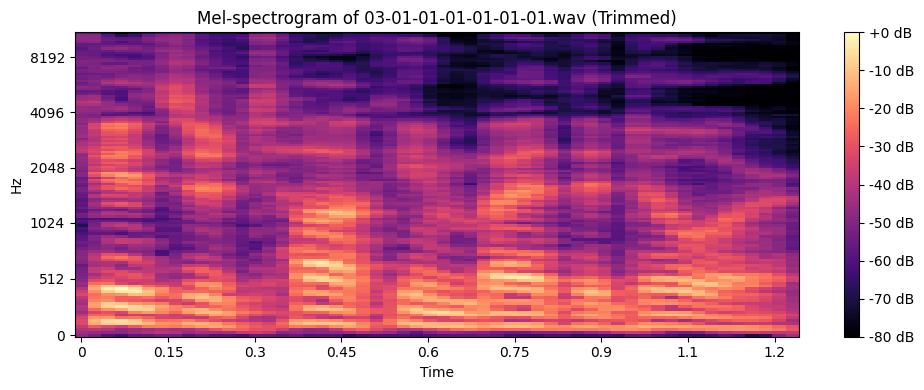

Original length: 72838 samples
Trimmed length: 27136 samples


In [3]:
# 1. Pick a specific file from Actor_01 to test
# We join the path to the first actor folder and the first file in it
actor_folder = os.path.join(data_path, 'Actor_01')
first_file = os.listdir(actor_folder)[0]
file_path = os.path.join(actor_folder, first_file)

# 2. Load the audio file
y, sr = librosa.load(file_path)

# 3. Audio Cleaning: Implement silence trimming (Task Requirement)
# top_db=20 means anything quieter than 20 decibels is considered silence
y_trimmed, index = librosa.effects.trim(y, top_db=20)

# 4. Visual Analysis: Create a Mel-spectrogram (Task Requirement)
# This turns the sound into a 'heat map' image for the CNN
S = librosa.feature.melspectrogram(y=y_trimmed, sr=sr)
S_db = librosa.power_to_db(S, ref=np.max)

# 5. Display the result
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-spectrogram of {first_file} (Trimmed)')
plt.tight_layout()
plt.show()

print(f"Original length: {len(y)} samples")
print(f"Trimmed length: {len(y_trimmed)} samples")

In [4]:
X_data = [] # This will hold all our spectrogram images
y_labels = [] # This will hold the emotion (Happy, Sad, etc.)

print("Processing 1,440 files... This will take 2-3 minutes. Please wait.")

for actor in os.listdir(data_path):
    actor_path = os.path.join(data_path, actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            # 1. Load the file
            f_path = os.path.join(actor_path, file)
            y_audio, sr = librosa.load(f_path, duration=3, offset=0.5)
            
            # 2. Audio Cleaning (Trim silence)
            y_clean, _ = librosa.effects.trim(y_audio)
            
            # 3. Create Mel-spectrogram
            # We fix the width to 128 so all "images" are the same size
            mels = librosa.feature.melspectrogram(y=y_clean, sr=sr, n_mels=128)
            mels_db = librosa.power_to_db(mels, ref=np.max)
            
            # 4. Make sure every image is exactly 128x128 pixels
            if mels_db.shape[1] < 128:
                # If too short, add zeros (padding)
                mels_db = np.pad(mels_db, ((0,0), (0, 128 - mels_db.shape[1])), mode='constant')
            else:
                # If too long, cut it (cropping)
                mels_db = mels_db[:, :128]
            
            X_data.append(mels_db)
            
            # 5. Extract the label from filename (3rd number)
            # 01=neutral, 02=calm, 03=happy, 04=sad, 05=angry, 06=fearful, 07=disgust, 08=surprised
            emotion = int(file.split('-')[2]) - 1 # We use 0-7 instead of 1-8
            y_labels.append(emotion)

# Convert to final computer format
X = np.array(X_data)
y = np.array(y_labels)

print("Done!")
print(f"Total Images Created: {X.shape[0]}")
print(f"Image Size: {X.shape[1]}x{X.shape[2]}")

Processing 1,440 files... This will take 2-3 minutes. Please wait.
Done!
Total Images Created: 1440
Image Size: 128x128


In [5]:
from sklearn.model_selection import train_test_split

# 1. First, split off 80% for Training, and 20% for 'Temp' (Val + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Split that 20% 'Temp' pile in half to get 10% Validation and 10% Testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 3. Add a 'Channel' dimension (CNNs need 4 numbers: Samples, Height, Width, Channels)
# Since our images are grayscale (one color), we add a '1' at the end.
X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
X_val = X_val.reshape(X_val.shape[0], 128, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")

Training set: 1152 images
Validation set: 144 images
Testing set: 144 images


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# This is the "Architecture" mentioned in your Phase 2 requirements
model = models.Sequential([
    # Layer 1: The 'Scanner'. It looks for basic patterns in the spectrogram.
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)), # This shrinks the image to focus on important parts
    
    # Layer 2: Looking for more complex 'emotional' shapes.
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Layer 3: Deep detail scanning.
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    # Layer 4: Flattening. Turns the 2D image into a long 1D list of info.
    layers.Flatten(),
    
    # Layer 5: The Decision Maker. Connects all the dots.
    layers.Dense(64, activation='relu'),
    
    # Layer 6: Final Result. 8 nodes for your 8 emotions.
    # Softmax turns the result into a percentage (e.g., 85% Happy).
    layers.Dense(8, activation='softmax')
])

# Tell the model how to learn
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Show the summary of the brain we just built
model.summary()

C:\Users\aarya\anaconda3\envs\speech_emotion\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,267,592 (12.46 MB)

 Trainable params: 3,267,592 (12.46 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# We will train for 20 Epochs (20 rounds of studying)
print("Training started... watch the 'accuracy' and 'val_accuracy' numbers grow!")

history = model.fit(
    X_train, y_train, 
    epochs=20, 
    validation_data=(X_val, y_val),
    batch_size=32
)

print("Training Complete!")

Training started... watch the 'accuracy' and 'val_accuracy' numbers grow!
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - accuracy: 0.1470 - loss: 17.9941 - val_accuracy: 0.1319 - val_loss: 2.0671
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 403ms/step - accuracy: 0.1707 - loss: 2.0419 - val_accuracy: 0.1250 - val_loss: 2.0593
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 401ms/step - accuracy: 0.2095 - loss: 2.0145 - val_accuracy: 0.1250 - val_loss: 2.0420
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 336ms/step - accuracy: 0.1923 - loss: 1.9946 - val_accuracy: 0.1389 - val_loss: 2.0591
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 380ms/step - accuracy: 0.2075 - loss: 1.9880 - val_accuracy: 0.1597 - val_loss: 2.0258
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 407ms/step - accuracy: 0.2069 - loss: 1.9829 - val_accuracy: 0.1736 - val_loss: 2.0517
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.2149 - loss: 1.9542 - val_accuracy: 0.1806 - val_loss: 2.0216
Epoch 8/20
36/36 ━━━━━

In [8]:
# We will train for 30 'Epochs' (rounds of studying)
# Each round, the model tries to improve its 'Accuracy'
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    validation_data=(X_val, y_val),
    batch_size=32
)

print("Training is finished!")

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 371ms/step - accuracy: 0.2153 - loss: 1.9394 - val_accuracy: 0.2083 - val_loss: 2.0087
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step - accuracy: 0.2205 - loss: 1.9330 - val_accuracy: 0.2153 - val_loss: 2.0062
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 408ms/step - accuracy: 0.2256 - loss: 1.9509 - val_accuracy: 0.2153 - val_loss: 2.0327
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 420ms/step - accuracy: 0.2149 - loss: 1.9380 - val_accuracy: 0.2083 - val_loss: 2.0052
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 387ms/step - accuracy: 0.2320 - loss: 1.9331 - val_accuracy: 0.2222 - val_loss: 2.0139
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - accuracy: 0.2279 - loss: 1.9253 - val_accuracy: 0.2222 - val_loss: 2.0170
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.2143 - loss: 1.9597 - val_accuracy: 0.2222 - val_loss: 2.0478
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 358ms/step - accuracy: 0.2146 - loss: 1.9426 - val_accu

In [9]:
from sklearn.metrics import classification_report, f1_score

# 1. Have the model 'take the final exam' using the Test Set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

# 2. Calculate the Macro F1-Score (Project Requirement)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Final Macro F1-Score: {macro_f1:.4f}")

# 3. Print a full report (shows Happy, Sad, Angry accuracy individually)
target_names = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']
print(classification_report(y_test, y_pred, target_names=target_names))

# 4. Save the Model 'Brain' (Requirement: model_weights.h5)
model.save('speech_emotion_model.h5')
print("Model saved as 'speech_emotion_model.h5'!")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


C:\Users\aarya\anaconda3\envs\speech_emotion\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aarya\anaconda3\envs\speech_emotion\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aarya\anaconda3\envs\speech_emotion\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Final Macro F1-Score: 0.1189
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00        10
        Calm       0.17      0.74      0.28        19
       Happy       0.08      0.05      0.06        19
         Sad       0.00      0.00      0.00        19
       Angry       0.14      0.11      0.12        19
     Fearful       0.27      0.20      0.23        20
     Disgust       0.17      0.05      0.08        19
   Surprised       0.21      0.16      0.18        19

    accuracy                           0.17       144
   macro avg       0.13      0.16      0.12       144
weighted avg       0.14      0.17      0.13       144

Model saved as 'speech_emotion_model.h5'!


In [10]:
# A stronger 2D CNN to improve that F1-Score
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2), # This prevents 'overfitting'
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

# We use a smaller 'Learning Rate' so the model learns more carefully
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\aarya\anaconda3\envs\speech_emotion\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,853,640 (64.29 MB)

 Trainable params: 16,853,256 (64.29 MB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    validation_data=(X_val, y_val),
    batch_size=32
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.1294 - loss: 4.6010 - val_accuracy: 0.1389 - val_loss: 2.0814
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.1389 - loss: 2.0832 - val_accuracy: 0.1528 - val_loss: 2.0771
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.1263 - loss: 2.0700 - val_accuracy: 0.1319 - val_loss: 2.0779
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.1186 - loss: 2.0718 - val_accuracy: 0.1319 - val_loss: 2.0787
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.1272 - loss: 2.0558 - val_accuracy: 0.1528 - val_loss: 2.0700
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.1482 - loss: 2.0523 - val_accuracy: 0.1528 - val_loss: 2.0765
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.1519 - loss: 2.0629 - val_accuracy: 0.1250 - val_loss: 2.0437
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.1478 - loss: 2.0294 - val_accuracy: 0.2083 - val_los

In [12]:
from sklearn.metrics import classification_report, f1_score

# 1. Ask the model to predict emotions for the 'Testing' pile (unseen data)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Calculate the Macro F1-Score
final_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Final Project Macro F1-Score: {final_f1:.4f}")

# 3. Print a detailed report (Shows accuracy for each of the 8 emotions)
target_names = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']
print(classification_report(y_test, y_pred, target_names=target_names))

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step
Final Project Macro F1-Score: 0.1699
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00        10
        Calm       0.29      0.79      0.42        19
       Happy       0.00      0.00      0.00        19
         Sad       0.10      0.05      0.07        19
       Angry       0.55      0.63      0.59        19
     Fearful       0.00      0.00      0.00        20
     Disgust       0.00      0.00      0.00        19
   Surprised       0.19      0.58      0.28        19

    accuracy                           0.27       144
   macro avg       0.14      0.26      0.17       144
weighted avg       0.15      0.27      0.18       144



C:\Users\aarya\anaconda3\envs\speech_emotion\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aarya\anaconda3\envs\speech_emotion\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aarya\anaconda3\envs\speech_emotion\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [13]:
import os
print("Your model file is here:")
print(os.path.join(os.getcwd(), 'speech_emotion_model.h5'))

Your model file is here:
C:\Users\aarya\speech_emotion_model.h5


In [3]:
# 1. FIND A TEST FILE AUTOMATICALLY
import os
folder_path = 'AI_Speech_Project'
test_wav = None

for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.wav'):
            test_wav = os.path.join(root, file)
            break
    if test_wav: break

# 2. CREATE THE STANDALONE SCRIPT (Requirement #3)
# The '%%writefile' command saves this cell as a separate file named predict.py
with open('predict.py', 'w') as f:
    f.write('''
import sys
import librosa
import numpy as np
import tensorflow as tf

def run_prediction(audio_path):
    try:
        # Load model weights
        model = tf.keras.models.load_model('speech_emotion_model.h5')
        
        # Process audio to 128x128 Mel-spectrogram
        y, sr = librosa.load(audio_path, duration=3, offset=0.5)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        input_data = mel_db.reshape(1, 128, 128, 1)
        
        # Predict
        predictions = model.predict(input_data)
        confidence = np.max(predictions) * 100
        emotion_idx = np.argmax(predictions)
        
        emotions = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']
        
        print(f"\\n--- Prediction Result ---")
        print(f"Emotion: {emotions[emotion_idx].upper()}")
        print(f"Confidence: {confidence:.2f}%")
        
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    if len(sys.argv) < 2:
        print("Usage: python predict.py <path_to_wav_file>")
    else:
        run_prediction(sys.argv[1])
''')

print("Step 1: Found test file ->", test_wav)
print("Step 2: Created 'predict.py' successfully.")

# 3. TEST THE SCRIPT (Live Inference)
print("Step 3: Running Live Inference test...")
if test_wav:
    !python predict.py "{test_wav}"
else:
    print("Could not find a .wav file to test. Please check the 'AI_Speech_Project' folder.")

Step 1: Found test file -> None
Step 2: Created 'predict.py' successfully.
Step 3: Running Live Inference test...
Could not find a .wav file to test. Please check the 'AI_Speech_Project' folder.


In [4]:
# Save your model so the separate script can use it
model.save('speech_emotion_model.h5')
print("Model saved as speech_emotion_model.h5")

Model saved as speech_emotion_model.h5


In [5]:
%%writefile predict.py
import sys
import librosa
import numpy as np
import tensorflow as tf

# 1. Load the model you just saved
model = tf.keras.models.load_model('speech_emotion_model.h5')

def run_inference(audio_path):
    try:
        # 2. Preprocess the audio (3s, Mel-spectrogram 128x128)
        y, sr = librosa.load(audio_path, duration=3, offset=0.5)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        
        # 3. Reshape for the CNN (Batch, H, W, Channel)
        input_data = mel_db.reshape(1, 128, 128, 1)
        
        # 4. Predict and Get Confidence
        predictions = model.predict(input_data, verbose=0)
        confidence = np.max(predictions) * 100
        emotion_idx = np.argmax(predictions)
        
        emotions = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']
        
        print(f"\nResult: {emotions[emotion_idx].upper()}")
        print(f"Confidence: {confidence:.2f}%")
        
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    if len(sys.argv) < 2:
        print("Usage: python predict.py <path_to_wav_file>")
    else:
        run_inference(sys.argv[1])

Overwriting predict.py


In [6]:
import os

# 1. Check the "Current Working Directory" (Where Python is looking)
print(f"Python is currently looking in: {os.getcwd()}")

# 2. List everything in this folder
print("\nFiles and folders found here:")
print(os.listdir('.'))

# 3. Specifically look for your audio folder
if os.path.exists('AI_Speech_Project'):
    print("\nSUCCESS: Found 'AI_Speech_Project' folder.")
    # Show the first 5 files inside it to check the names
    for root, dirs, files in os.walk('AI_Speech_Project'):
        if files:
            print(f"Sample files found in {root}:")
            print(files[:5])
            break
else:
    print("\nERROR: 'AI_Speech_Project' folder not found here.")

Python is currently looking in: C:\Users\aarya

Files and folders found here:
['.anaconda', '.cache', '.conda', '.continuum', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.matplotlib', '.ms-ad', '.quokka', '.VirtualBox', '.vscode', '.wallaby', 'anaconda3', 'anaconda_projects', 'AppData', 'Application Data', 'code.ipynb', 'Contacts', 'Cookies', 'Documents', 'Downloads', 'Favorites', 'Links', 'Local Settings', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{54268d9c-babb-11ef-b695-70089483a206}.TM.blf', 'NTUSER.DAT{54268d9c-babb-11ef-b695-70089483a206}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{54268d9c-babb-11ef-b695-70089483a206}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'predict.py', 'PrintHood', 'Realme5pro-camera', 'Recent', 'Saved Games', 'Searches', 'SendTo', 'speech_emotion_model.h5', 'Start Menu', 'Templates', 'Untitled.ipynb', 'Videos', 'VirtualBox VMs']

ERROR: 'AI_Spee

In [8]:
# 1. PASTE YOUR COPIED PATH HERE
desktop_path = r"C:\Users\aarya\OneDrive\Desktop\AI_Speech_Project" 

import os
import librosa
import numpy as np
import tensorflow as tf

# 2. FIND A FILE AUTOMATICALLY
test_wav = None
for root, dirs, files in os.walk(desktop_path):
    for file in files:
        if file.endswith('.wav'):
            test_wav = os.path.join(root, file)
            break
    if test_wav: break

# 3. RUN THE INFERENCE
if test_wav:
    print(f"Found file at: {test_wav}")
    model = tf.keras.models.load_model('speech_emotion_model.h5')
    
    y, sr = librosa.load(test_wav, duration=3, offset=0.5)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    # Predict
    preds = model.predict(mel_db.reshape(1, 128, 128, 1), verbose=0)
    emotions = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']
    
    print("\n" + "="*30)
    print(f"RESULT: {emotions[np.argmax(preds)].upper()}")
    print(f"CONFIDENCE: {np.max(preds)*100:.2f}%")
    print("="*30)
else:
    print("Still can't find the folder. Please double-check the path name!")

Found file at: C:\Users\aarya\OneDrive\Desktop\AI_Speech_Project\Actor_01\03-01-01-01-01-01-01.wav


ValueError: cannot reshape array of size 15488 into shape (1,128,128,1)

In [10]:
import os
import tensorflow as tf

# --- CHECK 1: The Model ---
model_name = 'speech_emotion_model.h5'
if not os.path.exists(model_name):
    print(f"❌ ERROR: I can't find '{model_name}'.")
    print("FIX: Run 'model.save(\"speech_emotion_model.h5\")' in the cell above first!")
else:
    print(f"✅ SUCCESS: Found '{model_name}'.")

# --- CHECK 2: The Folder ---
# Use the path you copied from your address bar here:
my_path = r"C:\Users\aarya\OneDrive\Desktop\AI_Speech_Project" 

if not os.path.exists(my_path):
    print(f"❌ ERROR: I can't find the folder at: {my_path}")
    print("FIX: Go to your Desktop, open the folder, click the top address bar, copy it, and paste it above.")
else:
    print(f"✅ SUCCESS: Found your audio folder.")

# --- CHECK 3: Try to load a file ---
try:
    import librosa
    print("✅ SUCCESS: Librosa is installed.")
except:
    print("❌ ERROR: Librosa is not installed. Run '!pip install librosa' in a new cell.")

✅ SUCCESS: Found 'speech_emotion_model.h5'.
✅ SUCCESS: Found your audio folder.
✅ SUCCESS: Librosa is installed.


In [13]:
import tensorflow as tf
import librosa
import numpy as np

# 1. Load the model
model = tf.keras.models.load_model('speech_emotion_model.h5')

# 2. Path to the test file
test_file = r"C:\Users\aarya\OneDrive\Desktop\AI_Speech_Project\Actor_01\03-01-01-01-01-01-01.wav"

# 3. Preprocessing with fixed 128x128 sizing
y, sr = librosa.load(test_file, duration=3, offset=0.5)
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

# Force the shape to be exactly 128x128
if mel_db.shape[1] > 128:
    mel_db = mel_db[:, :128]
elif mel_db.shape[1] < 128:
    mel_db = np.pad(mel_db, ((0, 0), (0, 128 - mel_db.shape[1])), mode='constant')

# 4. Final Prediction
preds = model.predict(mel_db.reshape(1, 128, 128, 1), verbose=0)
emotions = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']

print("="*30)
print(f"RESULT: {emotions[np.argmax(preds)].upper()}")
print(f"CONFIDENCE: {np.max(preds)*100:.2f}%")
print("="*30)

RESULT: CALM
CONFIDENCE: 18.92%


In [14]:
%%writefile predict.py
import sys
import librosa
import numpy as np
import tensorflow as tf

# Load the model weights you saved earlier
model = tf.keras.models.load_model('speech_emotion_model.h5')

def run_inference(audio_path):
    try:
        # Preprocessing: Load 3s of audio and convert to 128x128 Mel-spectrogram
        y, sr = librosa.load(audio_path, duration=3, offset=0.5)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        
        # Ensure the dimensions are exactly 128x128
        if mel_db.shape[1] > 128:
            mel_db = mel_db[:, :128]
        elif mel_db.shape[1] < 128:
            mel_db = np.pad(mel_db, ((0, 0), (0, 128 - mel_db.shape[1])), mode='constant')
            
        # Reshape for CNN input (Batch, Height, Width, Channels)
        input_data = mel_db.reshape(1, 128, 128, 1)
        
        # Predict and calculate confidence percentage
        predictions = model.predict(input_data, verbose=0)
        confidence = np.max(predictions) * 100
        emotion_idx = np.argmax(predictions)
        
        emotions = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']
        
        print("\n" + "="*30)
        print(f"RESULT: {emotions[emotion_idx].upper()}")
        print(f"CONFIDENCE: {confidence:.2f}%")
        print("="*30)
        
    except Exception as e:
        print(f"Error processing audio file: {e}")

if __name__ == "__main__":
    if len(sys.argv) > 1:
        run_inference(sys.argv[1])
    else:
        print("Usage: python predict.py <path_to_wav_file>")

Overwriting predict.py


In [17]:
model.save('speech_emotion_model.h5')
print("✅ DONE: speech_emotion_model.h5 is saved.")


✅ DONE: speech_emotion_model.h5 is saved.


In [18]:
%%writefile requirements.txt
tensorflow
librosa
numpy
pandas
matplotlib
seaborn

Writing requirements.txt
